<a href="https://colab.research.google.com/github/hallmx/learning_ML/blob/master/UCI_Heart_Disease_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/content/drive')

# UCI Heart Disease: The full story

### Introduction

The UCI Heart Disease dataset is a popular dataset for machine learning application and experiment. It consists of a set of attributes relating to the presentation, risk factors, clinical observations and test results of several hundred patients presenting to hospital with acute chest pain. Each sample (patient) is labelled with the outcome, whether or not their chest pain was cardiac in origin as judged by the presence or absence of more than 50% stenosis of any one  coronary artery at angiography (the gold standard test and intervention for cardiac chest pain). Development of a machine learning model to predict cardiac chest pain based on clinical criteria could find use as an adjunct to timely  diagnosis of cardiac chest pain and as well as screening/triaging patients for urgent coronary intervention.

### Data
The original UCI Heart Disease dataset was collected from four sites (Cleveland, Switzerland, Hungary and VA hospital in Massuchusetts) and consisted of a total of 899 observations and 77 attributes. However, almost all ML application tend to use only a highly processed subset of the complete dataset containing only 303 samples (all from one center - Cleveland) and 13 attributes (+1 target variable). This is likely due to differences in data collection and varying levels of incompleteness in the data from the other centers. However, by simply dropping the data from the Swiss, Hungarian and Massachusetts centers important information may be lost. 

The data can be obtained from https://archive.ics.uci.edu/ml/datasets/Heart+Disease

## Aim
In this notebook we address the question 'can a machine learning model be built using all the UCI Heart Disease data which is comparable or better than those using only the single center 13 attribute dataset?'. 

Regardless of the answer, the complete dataset offers an opportunity to practice much of the basic knowledge and skills required for a data science project using scikit-learn. These incluse: 
* data processing with imputation, bucketting, labelling, encoding and scaling
* data processing pipelines
* using a wide range of classifiers
* selecting hyperparameters with gridsearch
* test set evaluation 
* feature selection and feature transformation
* ensembling
* evaluating ensemble on the test set and final result.

As a learning exercise, I have deliberatley avoided using some of sk-learn's higher level function (like imputers) in favour of writing custom classes, so the code is more verbose than it could be in places, but undersatnding is greater!

### Methods

In this notebook we create a flexible data processing pipeline which cleans, encodes, labels and scales the full 4 Center Cleveland Heart Disease dataset using combinations of scikit-learn and custom data processing steps. We also implement a number of feature selectionand transformation methods and evaluate the most successful within the pipeline. 

The following classifiers were compared using the processed dataset: (1) Logistic regression, (2)  K nearest neighbors, (3) decision tree, (4) random forest, (5) SVM, (6) XGBoost, and (7) Light GBM.

### Results
The best accuracy on the 13 attribute Cleveland dataset, 0.814 was obtained by the random forest classifier with grid search for optimal parameters. A best accuracy of 0.847 was obtained by the K nearset neighbor classifier on the full 4 center datatset after data processing. 

Test set evaluation of the single best model (KNN with n_neighbors = 18) trained with the processed full 4 center UCI Heart Disease dataset gave a precision of 0.868, recall 0.755, F1 score 0.808 and AUC-ROC of 0.798.

Two ensembles of classifiers were also evaluated with the full 4 center dataset, a voting ensemble and a stacked ensemble. Both gave slightly better results than the best single classifier. Best results were obtained with the stacking ensemble, which gave a precision of 0.857, recall 0.824, F1 score 0.808 and AUC-ROC of 0.816 in predicting cardiac disease in patients presenting to hospital with acute chest pain. 

### To do
* Multiple runs using different train/test splits (i.e. don't set random seeds) to examine the variability in our results
* Construct a null hypothesis and examine the statistical significance of the difference in results between the 13 attribute Cleveland dataset and the full 4 center UCI dataset using our model.
* Systematically explore the effect of different combinations of steps in our data processing pipeline on final results.

### Conclusion
We successfully built a data processing pipeline and machine learning model to predict cardiac disease in patients presenting to hospital with acute chest pain (AUC-ROC 0.82) and using the full 4 center UCI Heart Disease dataset.


## Notebook setup

In [0]:
# common imports 
import os, copy, statistics
import numpy as np
import pandas as pd
from tqdm import tqdm

# For plotting
import matplotlib.pyplot as plt
import seaborn as sns

# SKlearn imports
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder
from sklearn.impute import  SimpleImputer
from sklearn.linear_model import LogisticRegression, LinearRegression, BayesianRidge
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, GradientBoostingClassifier
from sklearn.svm import LinearSVC
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
# from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score, cross_val_predict
from sklearn.feature_selection import SelectKBest, chi2, f_classif, RFECV
from sklearn.metrics import accuracy_score,recall_score,precision_score,f1_score, roc_auc_score, roc_curve, confusion_matrix, precision_recall_curve
# from sklearn.neural_network import BernoulliRBM

# Others
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

In [0]:
# Manage warnings
import warnings
warnings.filterwarnings("ignore")
warnings.filterwarnings(action="ignore", category=DeprecationWarning)
warnings.filterwarnings(action="ignore", category=FutureWarning)

In [0]:
# view all columns at full width when displaying dataframes
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', -1)

## Set vars

In [0]:
n_folds = 10
score = 'accuracy'

In [0]:
# Make notebook output stable across multiple runs
import random
random.seed(142)

In [0]:
# Set a series of parameters to be gridsearched for each classifier 
# For comparison between models we will use the same set of gridsearch parameters throughout unless otherwise specified.
lr_params = {'C': [1e-1, 1e0, 1e1, 1e2], "penalty": ['none', 'L2']}
knn_params = {'n_neighbors': [10, 15, 20]}
dt_params = {'max_depth': [None, 1, 3, 5, 7]}
rf_params = {'criterion': ['gini'], 'bootstrap': [True], 'n_estimators': [12, 48, 124, 200], 'max_depth': [None, 6, 12, 24, 48]}
svc_params = {'C': [0.0001, 0.001, 0.10, 0.1, 1.0]}
xgb_params = {'n_estimators': [24, 48, 124, 256], 'learning_rate': [0.05, 0.1, 0.2], 'num_leaves': [124]} #'max_depth': [None, 4,8,16,24], 
lgbm_params = {'n_estimators': [24, 48, 124, 256], 'learning_rate': [0.05, 0.1, 0.2], 'num_leaves': [124]} #'max_depth': [None, 4,8,16,24], 

## UCI Cleveland 13 attribute dataset
 
First evaluate a series of models on the smaller, commonly used Cleveland 13 attribute dataset. The are only 303 samples in this datset , so a test set isn't really practical but we shall use accuracy from the validation set as our benchmark and baseling to beat using the complete 4 center dataset.  

In [74]:
# Get dataset and view 
root_dir = '/content/drive/My Drive'
data_path = root_dir+"/learning_ML/datasets"
heart_cle = pd.read_csv(data_path+'/CLE_HeartDisease.csv')

print('heart_cle')
print('=========')
print(f'Number observations: {heart_cle.shape[0]}')
print(f'Number attributes: {heart_cle.shape[1]}')
heart_cle.head()

heart_cle
Number observations: 303
Number attributes: 14


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


 Attribute descriptions
1. #3 (age)
2. #4 (sex)
3. #9 (cp)
4. #10 (trestbps)
5. #12 (chol)
6. #16 (fbs)
7. #19 (restecg)
8. #32 (thalach)
9. #38 (exang)
10. #40 (oldpeak)
11. #41 (slope)
12. #44 (ca)
13. #51 (thal)
14. #58 (target) (the predicted attribute; 1 = heart disease, 0 = no heart disease)

In [75]:
# Test for null values (there are none!)
print(f'Num null values in dataset: {heart_cle.isnull().sum().sum()}')

Num null values in dataset: 0


In [0]:
# Separate out labels (`target` column)
heart_cle_train = heart_cle.drop('target', axis=1)
heart_cle_targs = heart_cle['target']

In [77]:
# Examine ratio of target values (heart disease (+ve) vs no heart disease (-ve))
def get_ratio(df):
        return round(df.value_counts()[1]/df.count(), 2)

targs = heart_cle_targs
pd.DataFrame(
    data=[[targs.value_counts()[1], targs.value_counts()[0]],[round(get_ratio(targs), 2), 1-round(get_ratio(targs), 2)]], 
    columns = ['Heart disease +ve', 'Heart disease -ve'],
    index = ['Observations', 'Ratio'])

,Heart disease +ve,Heart disease -ve
Observations,165.00,138.00
Ratio,0.54,0.46


In [0]:
# n_fold cross validation
# Note evaluation metric (score) and n_fold are set in 'Set vars' above
def test_params(model, params, X, y, estimator="estimator"):
    grid = GridSearchCV(model, params, error_score=0, scoring=score, cv=n_folds, refit=True) 
    grid.fit(X, y)
    return [estimator, 
            grid.best_score_, 
            grid.best_params_, 
            round(grid.cv_results_['mean_fit_time'].mean(), 3), 
            round(grid.cv_results_['mean_score_time'].mean(), 3) 
           ]

In [79]:
# Find the best results for each classifier on the Cleveland 13 attribute dataset
clfs=[]
scaler=StandardScaler()
clfs.append(test_params(LogisticRegression(), lr_params, heart_cle_train, heart_cle_targs, estimator='Logistic Regression'))
clfs.append(test_params(KNeighborsClassifier(), knn_params, scaler.fit_transform(heart_cle_train), heart_cle_targs, estimator='K Neighbors'))
clfs.append(test_params(DecisionTreeClassifier(), dt_params, heart_cle_train, heart_cle_targs, estimator='Decision Tree'))
clfs.append(test_params(RandomForestClassifier(), rf_params, heart_cle_train, heart_cle_targs, estimator='Random Forest'))
clfs.append(test_params(LinearSVC(), svc_params, heart_cle_train, heart_cle_targs, estimator='Support Vector machine'))
clfs.append(test_params(XGBClassifier(), xgb_params, heart_cle_train, heart_cle_targs, estimator='XGBoost'))
clfs.append(test_params(LGBMClassifier(), lgbm_params, heart_cle_train, heart_cle_targs, estimator='LightGBM'))
         
#Display results in a dataframe
title=(f'Comparison of classifiers on processed Cleveland 13 attribute UCI Heart dataset ({n_folds}-fold cross validation, metric = {score})')
print(title)
print('='*len(title))
clf_cols = ['Estimator', 'Best accuracy', 'Best params', 'Time to fit(s)', 'Time to score(s)']
clf_df = pd.DataFrame(data=clfs, columns = clf_cols)
print(clf_df.to_string(index=False))

Comparison of classifiers on processed Cleveland 13 attribute UCI Heart dataset (10-fold cross validation, metric = accuracy)
              Estimator  Best accuracy                                                                    Best params  Time to fit(s)  Time to score(s)
 Logistic Regression     0.821720       {'C': 0.1, 'penalty': 'none'}                                                  0.012           0.001           
 K Neighbors             0.831720       {'n_neighbors': 10}                                                            0.001           0.002           
 Decision Tree           0.808065       {'max_depth': 3}                                                               0.002           0.001           
 Random Forest           0.841290       {'bootstrap': True, 'criterion': 'gini', 'max_depth': 24, 'n_estimators': 48}  0.134           0.009           
 Support Vector machine  0.762796       {'C': 0.1}                                                                

The random forest classifier with hyperparameters {'bootstrap': True, 'criterion': 'gini', 'max_depth': 6, 'n_estimators': 48} gives the best result, accuracy 0.841. We will see if we can match or better that with the complete dataset. 

## Get the 4 center unprocessed UCI Heart Disease data.

The complete original datsets from each of the 4 centers (Clevealnd, Switzerland, Hungray and VA) are also available for download from the UCI Heart website. They are in separate .data files which need a bit of processing in order to get into a form we can work with. 

We will call this dataset the 'UCI 4 center full datset' or 'heart_full'

In [80]:
path = data_path+"/UCI_HeartDiseaseFull"
os.listdir(path)

['cleveland.data',
 'switzerland.data',
 'va.data',
 'hungarian.data',
 'colnames.names']

In [0]:
# Unprocessed data is in .data files and consists of tab separated values in rows separated by '\n'
# Function takes in the unprocessed data files and returns a standard dataframe 
def create_df(data):
    rows = data.decode("utf-8", errors="ignore").replace("\n", " ").replace(" ", ",").replace("name", "\n").split('\n')
    data_arr = []
    for i, r in enumerate(rows):
        r = r[:-1]
        if i > 0: r = r[1:]
        r_split=r.split(",")
        if len(r_split) == 75:
            row = []
            for j in range(75):
                row.append(float(r_split[j]))
            data_arr.append(list(row))

    df = pd.DataFrame(data=data_arr)
    return df

In [82]:
# Load unprocesed data, call create_df to process it into a dataframe
# Combine the four datsets into a single dataframe with column names
heart_full = pd.DataFrame()
for filename in os.listdir(path):
  if str(filename) != "colnames.names":
      with open(path+"/"+filename, 'rb') as f:
          data = f.read()
          df = create_df(data)
          src_col = str(filename[:3])
          if len(df.columns) > 0: df.insert(2, "src", src_col)
          heart_full = pd.concat([heart_full, df], axis=0)
        
heart_full = heart_full.reset_index()

# Attributes and their meanings are given in a separate notebook 'UCI Heart disease: The full EDA'
attrs = ['src_idx', 'pt_id', 'ccf','src', 'age', 'sex', 'painloc', 'painexer', 
        'relrest', 'pncaden', 'cptype', 'restbp', 'htn', 'chol', 
        'smoke', 'cigsday', 'cigsyrs', 'fastsug', 'dm','famhist', 
        'restecg', 'ekgmo', 'ekgday', 'ekgyr', 'dig', 'prop', 
        'nitr', 'pro', 'diuretic', 'protocol', 'thaldur', 'thaltime',
        'met', 'thalach', 'thalrest', 'tpeakbps', 'tpeakbpd', 'dummy', 
        'trestbpd', 'exang', 'xhypo', 'oldpeak', 'slope', 'rldv5', 
        'rldv5e', 'ca', 'restckm', 'exerckm', 'restef', 'restwm', 
        'exeref', 'exerwm', 'thal', 'nu1', 'nu2', 'nu3', 'cmo', 'cday', 
        'cyr', 'target', 'lmt', 'ladprox', 'laddist', 'diag', 'cxmain', 
        'ramus', 'om1', 'om2', 'rcaprox', 'rcadist', 'nu4', 'nu5', 'nu6','nu7', 'nu8', 'nu9', 'nu10']
heart_full.columns = attrs

print(f'heart_full: {heart_full.shape}')
heart_full.head()

heart_full: (899, 77)


,src_idx,pt_id,ccf,src,age,sex,painloc,painexer,relrest,pncaden,cptype,restbp,htn,chol,smoke,cigsday,cigsyrs,fastsug,dm,famhist,restecg,ekgmo,ekgday,ekgyr,dig,prop,nitr,pro,diuretic,protocol,thaldur,thaltime,met,thalach,thalrest,tpeakbps,tpeakbpd,dummy,trestbpd,exang,xhypo,oldpeak,slope,rldv5,rldv5e,ca,restckm,exerckm,restef,restwm,exeref,exerwm,thal,nu1,nu2,nu3,cmo,cday,cyr,target,lmt,ladprox,laddist,diag,cxmain,ramus,om1,om2,rcaprox,rcadist,nu4,nu5,nu6,nu7,nu8,nu9,nu10
0,0,1.0,0.0,cle,63.0,1.0,-9.0,-9.0,-9.0,-9.0,1.0,145.0,1.0,233.0,-9.0,50.0,20.0,1.0,-9.0,1.0,2.0,2.0,3.0,81.0,0.0,0.0,0.0,0.0,0.0,1.0,10.5,6.0,13.0,150.0,60.0,190.0,90.0,145.0,85.0,0.0,0.0,2.3,3.0,-9.0,172.0,0.0,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0,6.0,-9.0,-9.0,-9.0,2.0,16.0,81.0,0.0,1.0,1.0,1.0,-9.0,1.0,-9.0,1.0,-9.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,-9.0,-9.0
1,1,2.0,0.0,cle,67.0,1.0,-9.0,-9.0,-9.0,-9.0,4.0,160.0,1.0,286.0,-9.0,40.0,40.0,0.0,-9.0,1.0,2.0,3.0,5.0,81.0,0.0,1.0,0.0,0.0,0.0,1.0,9.5,6.0,13.0,108.0,64.0,160.0,90.0,160.0,90.0,1.0,0.0,1.5,2.0,-9.0,185.0,3.0,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0,3.0,-9.0,-9.0,-9.0,2.0,5.0,81.0,2.0,1.0,2.0,2.0,-9.0,2.0,-9.0,1.0,-9.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,-9.0,-9.0
2,2,3.0,0.0,cle,67.0,1.0,-9.0,-9.0,-9.0,-9.0,4.0,120.0,1.0,229.0,-9.0,20.0,35.0,0.0,-9.0,1.0,2.0,2.0,19.0,81.0,0.0,1.0,0.0,0.0,0.0,1.0,8.5,6.0,10.0,129.0,78.0,140.0,80.0,120.0,80.0,1.0,0.0,2.6,2.0,-9.0,150.0,2.0,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0,7.0,-9.0,-9.0,-9.0,2.0,20.0,81.0,1.0,1.0,1.0,1.0,-9.0,1.0,-9.0,1.0,-9.0,2.0,2.0,1.0,1.0,1.0,7.0,3.0,-9.0,-9.0
3,3,4.0,0.0,cle,37.0,1.0,-9.0,-9.0,-9.0,-9.0,3.0,130.0,0.0,250.0,-9.0,0.0,0.0,0.0,-9.0,1.0,0.0,2.0,13.0,81.0,0.0,1.0,0.0,0.0,0.0,1.0,13.0,13.0,17.0,187.0,84.0,195.0,68.0,130.0,78.0,0.0,0.0,3.5,3.0,-9.0,167.0,0.0,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0,3.0,-9.0,-9.0,-9.0,2.0,4.0,81.0,0.0,1.0,1.0,1.0,-9.0,1.0,-9.0,1.0,-9.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,-9.0,-9.0
4,4,6.0,0.0,cle,41.0,0.0,-9.0,-9.0,-9.0,-9.0,2.0,130.0,1.0,204.0,-9.0,0.0,0.0,0.0,-9.0,1.0,2.0,2.0,7.0,81.0,0.0,0.0,0.0,0.0,0.0,1.0,7.0,-9.0,9.0,172.0,71.0,160.0,74.0,130.0,86.0,0.0,0.0,1.4,1.0,-9.0,40.0,0.0,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0,3.0,-9.0,-9.0,-9.0,2.0,18.0,81.0,0.0,1.0,1.0,1.0,-9.0,1.0,-9.0,1.0,-9.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,-9.0,-9.0


## Preprocessing

In [0]:
# Retain only those attributes that contain relevant data
# Don't include columns marked in the dataset as dummy, irrelevant, unused, junk or name
# and where column information provides no medical value
# Also, don't include indexing columns

attrs = ['age', 'sex', 'painloc', 'painexer', 
        'relrest', 'pncaden', 'cptype', 'restbp', 'htn', 'chol', 'smoke', 
        'cigsday', 'cigsyrs', 'fastsug', 'dm','famhist', 
        'restecg','dig', 'prop', 
        'nitr', 'pro', 'diuretic', 'thaldur', 'thaltime',
        'met', 'thalach', 'thalrest', 'tpeakbps', 'tpeakbpd', 
        'trestbpd', 'exang', 'xhypo', 'oldpeak', 'slope', 'rldv5', 
        'rldv5e', 'ca','restef', 'restwm', 
        'exeref', 'exerwm', 'thal','target', 'lmt', 'ladprox', 'laddist', 'diag', 'cxmain', 
        'ramus', 'om1', 'om2', 'rcaprox', 'rcadist']

heart_full_base = heart_full[attrs]


In [84]:
# Looking through the dataset it is clear that null values were encoded as -9.0
# ... so lets replace all -9.0 with np.nan
heart_full_base.replace(-9.0, np.nan, inplace=True)

# In some columns a zero has been used to indicate absent values
# ... this is apparant where 0 is a medically impossible value (e.g. cholesterol level)
# ... so let's also convert those to NaN
cols = ['chol']
for col in cols: 
    heart_full_base[col] = heart_full_base[col].replace(0.0, np.nan) 

# Then drop all columns with >80% null values
null_thresh = 0.8
heart_full_base = heart_full_base.loc[:, heart_full_base.isnull().mean() <= null_thresh]

# Then review the number of null values in each column - there are still lots!
heart_full_base.isnull().sum()

age         0  
sex         0  
painloc     282
painexer    282
relrest     286
cptype      0  
restbp      59 
htn         34 
chol        202
smoke       669
cigsday     420
cigsyrs     432
fastsug     90 
famhist     422
restecg     2  
dig         68 
prop        66 
nitr        65 
pro         63 
diuretic    82 
thaldur     56 
thaltime    453
met         105
thalach     55 
thalrest    56 
tpeakbps    63 
tpeakbpd    63 
trestbpd    59 
exang       55 
xhypo       58 
oldpeak     62 
slope       308
rldv5       425
rldv5e      142
ca          608
thal        477
target      0  
lmt         275
ladprox     236
laddist     246
diag        558
cxmain      235
ramus       567
om1         271
om2         572
rcaprox     245
rcadist     270
dtype: int64

There are a large number of null values in almost all columns. We will need to do a lot of data cleaning to get this dataset ready for modelling without losing too much data. 

## EDA

We carry out an details EDA of this full UCI Heart dataset in the companion notebook: `UCI Heart disease: The full EDA` and so for brvity won't repeat any EDA here.

## Split into train and test sets

In [85]:
# Before doing any further processing lets set aside our test set and not touch it until we need to evaluate our final model
test_set_fraction = 0.25

heart_full_base_train = heart_full_base.sample(frac=1-test_set_fraction,random_state=142) #random state is a seed value
heart_full_base_test = heart_full_base.drop(heart_full_base_train.index)

def get_df_ratio(df1, df2):
    return round(len(df1)/(len(df1)+len(df2)), 2)

df_labels = pd.DataFrame(data=[
    [len(heart_full_base_train),len(heart_full_base_test)],
    [get_df_ratio(heart_full_base_train, heart_full_base_test), 1-get_df_ratio(heart_full_base_train, heart_full_base_test)]], 
    columns = ['Train', 'Test'],
    index = ['Observations', 'Ratio'])
df_labels

,Train,Test
Observations,674.00,225.00
Ratio,0.75,0.25


In [86]:
heart_full_base_train.shape, heart_full_base_test.shape

((674, 47), (225, 47))

## Decide on a target variable

The gold standard of the presence or absence of heart disease used in this dataset is whether or not any coronary artery narrowings >50% were present at cardaic angiography. 
Each of 'lmt', 'ladprox', 'laddist', 'diag', 'cxmain', 'ramus', 'om1', 'om2', 'rcaprox', 'rcadist' columns all represents a coronary artery, where a '1' represents at least one 
narrowing or >50% was seen in that artery at angiography, and a '0' means no narrowing > 50% were seen.

To be consistent with the Cleveland 13 attribute dataset, lest create a new 'target' column where: 
* 0 = no narrowings > 50% in ANY coronary artery at angiography (i.e. no significant coronary artery disease)
* 1 = at least one coronary artery with > 50% stenosis (i.e. significant disease)

We will keep the individual coronary artery target attribute columns in y_train_base and possibly make use of them later in a deeper analysis of outcomes. 

In [0]:
# Separate out the target variables into separate dataframe
targ_cols = ['target', 'lmt', 'ladprox', 'laddist', 'diag', 'cxmain', 'ramus', 'om1', 'om2', 'rcaprox', 'rcadist']

def get_targets(df, cols=None):
    y = df[targ_cols]
    X = df.drop(targ_cols, axis=1)

    #Clean up the target variables
    for col in cols[1:]:
        y.loc[y[col] == 1.0, col] = 0
        y.loc[y[col] == 2.0, col] = 1
        y[col].replace(np.nan, 0, inplace=True)
        
    y.insert(1, 'targ_num', y['target'])
    y.loc[y['target'] > 0.0, 'target'] = 1.0
    
    return X, y

X_train_base, y_train_base = get_targets(heart_full_base_train, targ_cols)
X_test_base, y_test_base = get_targets(heart_full_base_test, targ_cols)

In [88]:
X_train_base.shape, y_train_base.shape, X_test_base.shape, y_test_base.shape

((674, 36), (674, 12), (225, 36), (225, 12))

In [89]:
y_train_base.head()

,target,targ_num,lmt,ladprox,laddist,diag,cxmain,ramus,om1,om2,rcaprox,rcadist
650,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
520,1.0,3.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
108,1.0,2.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
418,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
897,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [90]:
# The ratio of target values is similar to the Cleveland 13 attribute dataset (see above)
def get_ratio(df):
        return round(df.value_counts()[1]/df.count(), 2)

targs = y_train_base['target']
pd.DataFrame(
    data=[[targs.value_counts()[1], targs.value_counts()[0]],[round(get_ratio(targs), 2), 1-round(get_ratio(targs), 2)]], 
    columns = ['Heart disease +ve', 'Heart disease -ve'],
    index = ['Observations', 'Ratio'])

,Heart disease +ve,Heart disease -ve
Observations,364.00,310.00
Ratio,0.54,0.46


## Data Cleaning pipeline

### Define attribute types 

In [91]:
# Now that we have had a close look at the data
# ... we can assign datatypes to the attributes

# nominal variables (unordered catagories)
nom_vars = ['sex', 'painloc', 'painexer', 'relrest','htn', 'fastsug', 'famhist', 
            'smoke', 'dig', 'prop', 'nitr', 'pro', 'diuretic','restecg', 'exang', 'xhypo','thal',]

# ordinal variables (ordered catagories)
ord_vars = ['ca', 'slope','cptype']

# continuous variables (we could further divide this group into interval and ration variables but lets see if we need to first)
cont_vars = ['age', 'restbp','chol', 'cigsday', 'cigsyrs', 'thaldur', 'thaltime','met', 
            'thalach', 'thalrest', 'tpeakbps', 'tpeakbpd', 'trestbpd','oldpeak','rldv5', 'rldv5e']

# check we have assigned all attributes
print(f'All atttributes assigned: {len(X_train_base.columns) == len(nom_vars) + len(ord_vars) + len(cont_vars)}')

All atttributes assigned: True


### Prepare data for machine learning using custom pipelines

In [0]:
# The 'painloc', 'painexer' and 'relrest' fields are related to the 'cptype' field
# They have a high number if null values (about 30%) but may still contain useful information
# Lets fill the null values in these columns with the most common value depending on the type of pain in 'cptype'

class CustomAttributeImputer(TransformerMixin):
    def __init__(self, drop_originals=False):
        self.pain_cols = ['painloc', 'painexer', 'relrest']
        self.drop_originals = drop_originals
    def transform(self, df):   
        X = df.copy()
        for col in self.pain_cols:
            X[f'{col}_imp'] = np.where(X[col].isnull(), 1, 0)
        
        X.loc[(X['painloc'].isnull()) & (X['cptype'] == 1.0), 'painloc'] = 0.0
        X.loc[(X['painloc'].isnull()) & (X['cptype'] == 2.0), 'painloc'] = 1.0
        X.loc[(X['painloc'].isnull()) & (X['cptype'] == 3.0), 'painloc'] = 1.0
        X.loc[(X['painloc'].isnull()) & (X['cptype'] == 4.0), 'painloc'] = 1.0
        
        X.loc[(X['painexer'].isnull()) & (X['cptype'] == 1.0), 'painexer'] = 0.0
        X.loc[(X['painexer'].isnull()) & (X['cptype'] == 2.0), 'painexer'] = 1.0
        X.loc[(X['painexer'].isnull()) & (X['cptype'] == 3.0), 'painexer'] = 0.0
        X.loc[(X['painexer'].isnull()) & (X['cptype'] == 4.0), 'painexer'] = 1.0
 
        X.loc[(X['relrest'].isnull()) & (X['cptype'] == 1.0), 'relrest'] = 0.0
        X.loc[(X['relrest'].isnull()) & (X['cptype'] == 2.0), 'relrest'] = 0.0
        X.loc[(X['relrest'].isnull()) & (X['cptype'] == 3.0), 'relrest'] = 1.0
        X.loc[(X['relrest'].isnull()) & (X['cptype'] == 4.0), 'relrest'] = 1.0

        if self.drop_originals: X.drop(self.pain_cols, axis=1, inplace=True)
        return X
    def fit(self, *_):
        return self

In [0]:
# Impute missing values np.nan with a strategy: 'mean', 'median' (continuous variables) or 'most frequent' values. (categorical variables)
# Strategy can also be 'constant' in which case it fills with the default fill_value of 0

class StrategyImputer(TransformerMixin):
    def __init__(self, cols=None, missing_values=np.nan, strategy='mean', fill_value=0):
        self.cols = cols
        self.strategy = strategy
        self.missing_values = missing_values
        self.fill_value = fill_value
    def transform(self, df):
        X = df.copy()
        imp = SimpleImputer(missing_values=self.missing_values, strategy=self.strategy, fill_value=self.fill_value)
        for col in self.cols:
            X[f'{col}_imp'] = np.where(X[col].isnull(), 1, 0)
            X[col] = imp.fit_transform(X[[col]])
        return X
    def fit(self, *_):
        return self

In [0]:
# Impute missing values based on predictions from other features
# Custom implementation of sklearn's the IterativeImputer class

class PredictionImputer(TransformerMixin):
    def __init__(self, cols=None, initial_strategy='mean', estimator='knn'):
        self.cols = cols
        self.initial_strategy = initial_strategy
        # Select a classifier or regressor depending on estimator parameter
        if estimator == 'knn': 
            self.estimator = KNeighborsClassifier(n_neighbors=15, weights='distance')
        elif estimator == 'rfr': 
            self.estimator = RandomForestRegressor(n_estimators=124)
        elif estimator == 'brr':
            self.estimator = BayesianRidge()
        else: self.estimator = LogisticRegression(C=0.1)
    def initialize_impute(self, df):
        # first drop any columns with all null values
        df.dropna(axis=1,how='all', inplace=True)
        if self.initial_strategy == 'median': 
            df.fillna(df.median(), inplace=True)
        else: 
            df.fillna(df.mean(), inplace=True)
        return df
    def transform(self, df):
        X = df.copy()
        for col in self.cols:
            # create a new column to record imputed values
            df[f'{col}_imp'] = np.where(df[col].isnull(), 1, 0)
            X_targs = X[col]
            X = self.initialize_impute(X)
            X[col] = X_targs
            
            # create a new df with only observations with NO missing values in col
            # this will be used to train the estimator
            df_no_nulls_train = X[df[col].notnull()]
            # separate out the targets
            df_no_nulls_targ = df_no_nulls_train[col]
            # ... then drop the target col from the training set
            df_no_nulls_train.drop(col, axis=1, inplace=True)

            # create a dataframe of the null observations 
            df_nulls = X[df[col].isnull()]
            df_nulls.drop(col, axis=1, inplace=True)
            
            # fit and make predictions of null values
            vals_imputed = self.estimator.fit(df_no_nulls_train, df_no_nulls_targ).predict(df_nulls)
            df.loc[df[col].isnull(), col] = vals_imputed
        return df
    def fit(self, *_):
        return self


In [0]:
# Bucketting some continuous variables
class Bucketter(TransformerMixin):
    def __init__(self, cols=None, bins=5, labels=False):
        self.cols = cols
        self.bins = bins
        self.labels = labels
    def transform(self, df):
        X = df.copy()
        for i, col in enumerate(self.cols):
            X[col] = pd.cut(X[col], bins=self.bins[i], labels=self.labels)
        return X
    def fit(self, *_):
        return self

In [0]:
# Create a custom imputer pipeline for continuous variables
cont_imputer = Pipeline([ 
    ('impute_zeros', StrategyImputer(cols=['cigsday', 'cigsyrs'], strategy='constant', fill_value=0)),
    ('impute_mean', StrategyImputer(cols=[], strategy='mean')), 
    ('impute_predicted_cont_vars', PredictionImputer(cols = ['chol','restbp', 'thaldur', 'thaltime','thalach', 'thalrest', 'tpeakbpd','tpeakbps', 'trestbpd', 'met', 'oldpeak', 'rldv5', 'rldv5e'], 
            initial_strategy='mean', estimator='rfr')),
    ('bucket_attributes', Bucketter(cols=['cigsday', 'cigsyrs'], bins=[8,8]))
])

In [0]:
# Create a custom imputer pipeline for catagorical variables
cat_imputer = Pipeline([ 
    ('impute_custom_attributes', CustomAttributeImputer(drop_originals=False)), 
    ('impute_most_freq', StrategyImputer(cols=[], strategy='most_frequent')),
    ('impute_zeros', StrategyImputer(cols=['restecg', 'smoke'], strategy='constant', fill_value=0)),
    ('impute_predicted_cat_vars', PredictionImputer(cols = ['htn', 'fastsug', 'famhist', 'exang', 'xhypo', 'ca', 'thal', 'slope'], # 
            initial_strategy='mean', estimator='knn')),
])

In [0]:
# Create new columns for the difference between physiological and ecg parameters at rest and at peak exercise during exercise testing
# The change in these values is of greater clinical importance than the absolute values themselves
class CreateDiffs(TransformerMixin):
    def __init__(self, cols, drop_originals=False):
        self.cols = cols
        self.drop_originals = drop_originals
    def transform(self, df):
        X = df.copy()
        for col in self.cols:
            (col1, col2, newcol) = col
            X.insert(X.columns.get_loc(col1)+1, newcol, X[col2] - X[col1])
            if self.drop_originals: X.drop([col1, col2], axis=1, inplace=True)
        return X
    def fit(self, *_):
        return self

In [0]:
# Add a column which adds up all the individual meds taken during exercise testing into a new column 'extestmeds'
# First ensure all individual med columns only contain 0 or 1's
# Bucketting some continuous variables
class CreateThalMeds(TransformerMixin):
    def __init__(self, drop_originals=False):
        self.cols = ['dig', 'prop', 'nitr', 'pro', 'diuretic']
        self.drop_originals = drop_originals
    def transform(self, df):
        X = df.copy()
        for col in self.cols:
            X.loc[X[col] > 0.0, col] = 1
            X[col].fillna(0, inplace=True)
        X.insert(19, 'thalmeds', X['dig']+X['prop']+X['nitr']+X['pro']+X['diuretic'])
        if self.drop_originals: X.drop(self.cols, axis=1, inplace=True)
        return X
    def fit(self, *_):
        return self

In [0]:
create_attribs = Pipeline([
    ("create_diff_attribs", CreateDiffs(cols=[('thalrest', 'thalach', 'thalhrdiff'),('trestbpd', 'tpeakbpd', 'tbpddiff'),('rldv5', 'rldv5e', 'rldlv5diff')], drop_originals=False)),
    ("create_thal_eds", CreateThalMeds(drop_originals=False)),     
])

In [0]:
# feature selection - remove highly corrolated columns
class SelectorHighCorr(TransformerMixin):
    def __init__(self, threshold=0.95):
        self.threshold = threshold
        self.attributes_to_drop = []
    def transform(self, df):
        X = df.copy()
        print(f'Highly corrolated features (>{self.threshold} corrolation) dropped: {len(self.attributes_to_drop)} ({self.attributes_to_drop})')
        X.drop(self.attributes_to_drop, axis=1, inplace=True)
        return X
    def fit(self, X, *_):
        corr_X = X.corr().abs()
        corr_X_upper = corr_X.where(np.triu(np.ones(corr_X.shape), k=1).astype(np.bool))
        self.attributes_to_drop = [column for column in corr_X_upper.columns if any(corr_X_upper[column] > self.threshold)]
        return self

In [0]:
feature_selector = Pipeline([
    ("selector_high_corr", SelectorHighCorr(threshold=0.95)),
])

In [0]:
# Scaler
class Scaler(TransformerMixin):
    def __init__(self, cols=None, scaler="standard"):
        self.cols = cols
        self.scaler = scaler
    def transform(self, df):
        X = df.copy()
        scaler = MinMaxScaler() if self.scaler == "minmax" else StandardScaler()
        for col in self.cols:
            if col in X:
                X[col] = scaler.fit_transform(X[col].values.reshape(-1,1))
            else:
                print(f"Scaler warning: attribute '{col}' not found")
        return X
    def fit(self, *_):
        return self

In [0]:
# Some values need adjusting to ensure train and test sets 
# ... are of the same size after one hot encoding
class ModifyAttribs(TransformerMixin):
    def __init__(self, cols=None):
        self.cols = cols
    def transform(self, df):
        X = df.copy()
        if 'thal' in X: # 'thal' should have values 3.0, 6.0 or 7.0 only.
            X.loc[X['thal'] < 3.0, 'thal'] = 3.0
            X.loc[(X['thal'] == 4.0) | (X['thal'] == 5), 'thal'] = 6.0
            X.loc[X['thal'] > 7.0, 'thal'] = 7.0
        else:  
            print(f"ModifyAttrib warning: attribute 'thal' not found")
       
        if 'ca' in X: # 'ca' attribute should have values in range 1.0 - 4.0 only
            X.loc[X['ca'] < 1.0, 'thal'] = 1.0
            X.loc[X['ca'] > 3.0, 'ca'] = 3.0
        else:
             print(f"ModifyAttrib warning: attribute 'ca' not found")
        if 'slope' in X: # 'slope' attribute should have values in range 1.0 - 3.0 only
            X.loc[X['slope'] < 1.0, 'slope'] = 1.0
            X.loc[X['slope'] > 3.0, 'slope'] = 3.0
        else:
            print(f"ModifyAttrib warning: attribute 'slope' not found")
        return X
    def fit(self, *_):
        return self

In [0]:
# Dummify nominal data
class Dummifier(TransformerMixin):
    def __init__(self, cols=None):
        self.cols = cols
    def transform(self, df):
        X = df.copy()
        if set(self.cols).issubset(X.columns):
            return pd.get_dummies(X, columns=self.cols)
        else:
            missing_cols = list(set(self.cols)-set(X.columns))
            print(f'Dummifier error: attribute(s) {missing_cols} not found')
            present_cols = [col for col in self.cols if col not in missing_cols]
            return pd.get_dummies(X, columns=present_cols)
    def fit(self, *_):
        return self

In [0]:
# Label encode nominal data
class Encoder(TransformerMixin):
    def __init__(self, cols=None):
        self.cols = cols
    def transform(self, df):
        X = df.copy()
        encoder = LabelEncoder()
        for col in self.cols:    
            if col in X:
                encoder.fit(list(X[col].values) + list(X[col].values))
                X[col] = encoder.transform(list(X[col].values))
            else: 
                print(f"LabelEncoder warning: attribute(s) '{col}' not found")
        return X
    def fit(self, *_):
        return self

### Run data cleaning pipeline

In [107]:
preprocessing_pipe = Pipeline([
    ('cat_impute', cat_imputer), 
    ('cont_impute', cont_imputer),
    ('create_attribs', create_attribs),
    ('feature_select', feature_selector),
    ('modify_attribs', ModifyAttribs(cols=[])),
    ("dummify", Dummifier(cols=['cptype','thal', 'slope', 'restecg', 'ca'])), 
    ("label_encode", Encoder(cols=[])), 
    ('scale', Scaler(cols=['age', 'restbp', 'chol', 'oldpeak','thaldur', 'thaltime', 
                                 'met','thalhrdiff', 'tpeakbps', 'tbpddiff', 'tpeakbpd','trestbpd', 
                                 'thalach', 'thalrest', 'rldv5', 'rldv5e', 'rldlv5diff', ], 
                           scaler='standard'))
])
# fit_transform the training set
X_train_df = preprocessing_pipe.fit_transform(X_train_base)

# transform the test set
# remember we just TRANSFORM the test set (NOT FIT it so we use the same parameters, mean etc as the train set during the transform)
X_test_df = preprocessing_pipe.transform(X_test_base)

Highly corrolated features (>0.95 corrolation) dropped: 12 (['rldv5e', 'painexer_imp', 'relrest_imp', 'xhypo_imp', 'ca_imp', 'cigsyrs_imp', 'restbp_imp', 'thaldur_imp', 'thalach_imp', 'thalrest_imp', 'tpeakbps_imp', 'trestbpd_imp'])
Scaler warning: attribute 'rldv5e' not found
Highly corrolated features (>0.95 corrolation) dropped: 12 (['rldv5e', 'painexer_imp', 'relrest_imp', 'xhypo_imp', 'ca_imp', 'cigsyrs_imp', 'restbp_imp', 'thaldur_imp', 'thalach_imp', 'thalrest_imp', 'tpeakbps_imp', 'trestbpd_imp'])
Scaler warning: attribute 'rldv5e' not found


In [108]:
# Wow! we've dealt with all the missing values.
print(f'Num missing values: {X_train_df.isnull().sum().sum()}')

Num missing values: 0


### View final dataset

In [109]:
print('train data')
print('====')
print(f'Num rows: {X_train_df.shape[0]}')
print(f'Num cols: {X_train_df.shape[1]}')
display(X_train_df.head())
print('targets')
print('=======')
print(f'Num rows: {y_train_base.shape[0]}')
print(f'Num cols: {y_train_base.shape[1]}')
display(y_train_base.head())
print('test data')
print('====')
print(f'Num rows: {X_test_df.shape[0]}')
print(f'Num cols: {X_test_df.shape[1]}')
display(X_test_df.head())

train data
====
Num rows: 674
Num cols: 69


,age,sex,painloc,painexer,relrest,restbp,htn,chol,smoke,cigsday,cigsyrs,fastsug,famhist,dig,prop,nitr,pro,thalmeds,diuretic,thaldur,thaltime,met,thalach,thalrest,thalhrdiff,tpeakbps,tpeakbpd,trestbpd,tbpddiff,exang,xhypo,oldpeak,rldv5,rldlv5diff,painloc_imp,restecg_imp,smoke_imp,htn_imp,fastsug_imp,famhist_imp,exang_imp,thal_imp,slope_imp,cigsday_imp,chol_imp,thaltime_imp,tpeakbpd_imp,met_imp,oldpeak_imp,rldv5_imp,rldv5e_imp,cptype_1.0,cptype_2.0,cptype_3.0,cptype_4.0,thal_1.0,thal_3.0,thal_6.0,thal_7.0,slope_1.0,slope_2.0,slope_3.0,restecg_0.0,restecg_1.0,restecg_2.0,ca_0.0,ca_1.0,ca_2.0,ca_3.0
650,0.575657,1.0,1.0,0.0,1.0,-0.146404,0.0,1.336651,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.483093,-0.057526,-0.374424,-0.710006,-1.803495,0.317779,-0.487285,0.890004,-0.381736,1.197482,1.0,0.0,0.097918,-1.022189,-0.557969,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,1,0,0,1,0,0,0
520,1.103395,1.0,1.0,1.0,1.0,0.034881,0.0,1.105716,0.0,1,3,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.050807,0.345820,-0.242546,0.469507,0.036627,0.502209,-0.020350,0.033737,-0.137184,0.130776,0.0,0.0,0.091931,0.868943,-0.806539,0,0,0,0,0,0,1,1,1,0,0,1,1,1,1,1,1,0,0,0,1,0,1,0,0,0,1,0,0,1,0,0,1,0,0
108,0.786753,1.0,1.0,1.0,1.0,-0.696021,1.0,0.220462,0.0,0,2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.483093,-0.057526,-0.245914,0.078455,-1.088436,0.758421,-0.648230,-0.847187,-0.381736,-0.621434,1.0,0.0,2.510804,1.013000,1.004555,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,1,0,1,0,0,0,1,0,0
418,0.997848,1.0,1.0,0.0,1.0,-0.006783,1.0,-0.585484,0.0,0,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.194143,0.322942,-0.102376,0.577920,0.066037,0.605262,-0.223478,0.182799,-0.043580,0.221722,1.0,0.0,-0.089186,0.908788,-0.830241,0,0,0,1,0,0,1,1,1,0,1,1,1,1,1,1,1,0,0,1,0,1,0,0,0,0,1,0,0,0,1,1,0,0,0
897,-0.690914,0.0,0.0,0.0,0.0,0.403213,1.0,0.162729,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.765663,-0.185310,-0.406552,-0.118660,0.627704,-0.519441,-0.889647,0.195128,0.663932,-0.257651,0.0,0.0,0.097918,-0.895501,-0.557969,0,0,1,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,0


targets
Num rows: 674
Num cols: 12


,target,targ_num,lmt,ladprox,laddist,diag,cxmain,ramus,om1,om2,rcaprox,rcadist
650,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
520,1.0,3.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
108,1.0,2.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
418,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
897,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


test data
====
Num rows: 225
Num cols: 69


,age,sex,painloc,painexer,relrest,restbp,htn,chol,smoke,cigsday,cigsyrs,fastsug,famhist,dig,prop,nitr,pro,thalmeds,diuretic,thaldur,thaltime,met,thalach,thalrest,thalhrdiff,tpeakbps,tpeakbpd,trestbpd,tbpddiff,exang,xhypo,oldpeak,rldv5,rldlv5diff,painloc_imp,restecg_imp,smoke_imp,htn_imp,fastsug_imp,famhist_imp,exang_imp,thal_imp,slope_imp,cigsday_imp,chol_imp,thaltime_imp,tpeakbpd_imp,met_imp,oldpeak_imp,rldv5_imp,rldv5e_imp,cptype_1.0,cptype_2.0,cptype_3.0,cptype_4.0,thal_1.0,thal_3.0,thal_6.0,thal_7.0,slope_1.0,slope_2.0,slope_3.0,restecg_0.0,restecg_1.0,restecg_2.0,ca_0.0,ca_1.0,ca_2.0,ca_3.0
5,0.292134,1.0,1.0,1.0,0.0,-0.544124,1.0,-0.363629,0.0,1,2,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.680774,0.944786,-0.047709,1.647114,-0.211022,1.842002,-0.194713,-1.247573,-0.745319,-0.657956,0.0,0.0,0.051086,0.919772,1.418377,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,0
11,0.292134,0.0,1.0,1.0,0.0,0.487987,0.0,0.646516,0.0,0,0,0.0,0.0,0.0,1.0,1.0,0.0,2.0,0.0,-1.053531,-0.330353,-0.402406,0.651805,0.587692,0.311906,1.364225,2.217232,1.552475,0.991542,0.0,0.0,0.579991,1.078336,2.298269,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,0,1,1,0,0,0
12,0.292134,1.0,1.0,0.0,1.0,-0.028069,0.0,-0.015303,0.0,2,3,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.114350,1.672400,-0.047709,0.213869,-0.144463,0.311906,-0.994169,-0.020455,0.633358,-0.514521,1.0,0.0,-0.160476,1.019806,1.084493,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0,0,1,0,1,0,0
16,-0.568489,1.0,1.0,1.0,0.0,-1.060179,1.0,-0.485544,0.0,0,0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.298206,0.738432,-0.165941,1.248990,-0.077903,1.345754,0.205015,-0.525739,-0.285760,-0.299370,0.0,0.0,0.262648,0.981495,2.725707,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,1,1,0,0,1,0,0,0
22,0.507290,1.0,1.0,1.0,0.0,-0.544124,0.0,0.472353,0.0,0,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.349215,-0.795586,-0.165941,0.930492,-0.477260,1.263047,0.005151,-1.969408,-1.204877,-1.016542,0.0,0.0,1.108896,0.898488,1.759841,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,0,1,1,0,0,0


## Classifiers

### set up.

In [0]:
X_train = np.array(X_train_df.copy(deep=True))
y_train = np.array(y_train_base['target'].copy(deep=True))
X_test = np.array(X_test_df.copy(deep=True))
y_test = np.array(y_test_base['target'].copy(deep=True))

In [0]:
# Note, XGBoost prefers datarames converted to arrays using as_matrix than np_array
X_train_matrix = X_train_df.copy().as_matrix()
y_train_matrix = y_train_base['target'].copy().as_matrix()
X_test_matrix = X_test_df.copy().copy().as_matrix()
y_test_matrix = y_test_base['target'].copy().as_matrix()

In [0]:
# n_fold cross validation + prediction on the test set with best model
# Note evaluation metric (score) and n_fold are set in 'Set vars' above
n_folds = 5
def test_models_params(model, params, X, y, estimator="model", search_func='grid', n_iter=12):
    if search_func == 'randomized':
        grid = RandomizedSearchCV(model, param_distributions=params, error_score=0, scoring=score, cv=n_folds, n_iter=n_iter, iid=False)
    else:
        grid = GridSearchCV(model, params, error_score=0, scoring=score, cv=n_folds)
    grid.fit(X, y)

    # get predictions
    y_preds = cross_val_predict(model, X, y, cv=10)

    cm = confusion_matrix(y_train,y_preds)
    sensitivity = cm[1,1]/(cm[1,1] + cm[1,0])
    specificity= cm[0,0]/(cm[0,0] + cm[0,1])
    auc=roc_auc_score(y_train,y_preds)

    print(grid.cv_results_['std_test_score'][grid.best_index_]) # best score standard deviation
    print(grid.best_score_)
    
    return grid.best_estimator_, grid.best_params_, y_preds, [
        estimator, 
        grid.best_score_, 
        grid.best_params_,
        round(grid.cv_results_['mean_fit_time'].mean(), 3), 
        round(grid.cv_results_['mean_score_time'].mean(), 3),
        round(precision_score(y_train,y_preds), 6),
        round(recall_score(y_train,y_preds), 6),
        round(f1_score(y_train,y_preds), 6),
        sensitivity,
        specificity,
        auc
    ]

In [0]:
# Plotting functions

# Precision-recall curve
def plot_pr_curve(precisions, recalls, est=''):
    plt.plot(recalls[:-1], precisions[:-1], lw=2, color='darkorange')
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    # plt.axis([0, 1, 0, 1])
    plt.title(f'{est}\n\nPrecision-Recall Curve', pad='20', fontsize='16')

# Confusion matrix
def plot_cm(cm, idx=0, est=''):
    sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', linewidths=1, cbar=False)
    plt.xlabel("Predicted label", labelpad=10, fontsize='14')
    plt.ylabel("True label", fontsize='14', labelpad=10) if idx == 0 else None
    plt.title(f'{est}\n\nConfusion Matrix', pad='20', fontsize='16')

# ROC curve
def plot_roc(fpr, tpr, auc, idx=0, est=''):
    plt.plot(fpr, tpr, marker=".", label='ROC curve \n(AUC = %0.4f)'%auc, lw=2, color='darkorange')
    plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel("False Positive Rate", labelpad=10, fontsize='14')
    plt.ylabel("True Positive Rate", fontsize='14', labelpad=10) if idx == 0 else None
    plt.legend(loc="lower right", fontsize='14')
    plt.title(f'{est}\n\nROC Curve', fontsize='16', pad='20')
    

### Fit and evaluate validation set results

Comparison of classifiers trained on the full 4 center UCI Heart Disease Dataset (5 fold cross-validation). Predictions made using cross_val_predict
Fitting and predicting Logistic Regression...
0.034881947008750205
0.7982863460475401
Fitting and predicting K neighbors classifier...
0.035170469513916974
0.8323604201216142
Fitting and predicting decision tree classifier...
0.04672156386758227
0.786301824212272
Fitting and predicting random forest classifier...
0.03190433436883705
0.8278938640132669
Fitting and predicting linear SVM Classifier...
0.03464655724441678
0.8160751796572692
Fitting and predicting XGBoost Classifier...
0.03811752645518954
0.8115975677169708
Fitting and predicting LightGBM classifier...
0.036948742555939225
0.8249530127142067
Done!


,Estimator,Best training accuracy,Best params,Time to fit(s),Time to score(s),Precision,Recall,F1 score,Sensitivity (recall),Specificity,AUC-ROC
0,Logistic Regression,0.798286,"{'C': 0.1, 'penalty': 'none'}",0.022,0.000,0.828338,0.835165,0.831737,0.835165,0.796774,0.815970
1,K Neighbors Classifier,0.832360,{'n_neighbors': 15},0.005,0.018,0.831099,0.851648,0.841248,0.851648,0.796774,0.824211
2,Decision Tree Classifier,0.786302,{'max_depth': 3},0.004,0.000,0.757660,0.747253,0.752420,0.747253,0.719355,0.733304
3,Random Forest Classifier,0.827894,"{'bootstrap': True, 'criterion': 'gini', 'max_depth': 24, 'n_estimators': 124}",0.176,0.009,0.819178,0.821429,0.820302,0.821429,0.787097,0.804263
4,Linear SVM,0.816075,{'C': 0.1},0.021,0.001,0.821918,0.824176,0.823045,0.824176,0.790323,0.807249
5,XGBoost Classifier,0.811598,"{'learning_rate': 0.05, 'n_estimators': 124, 'num_leaves': 124}",0.136,0.001,0.830084,0.818681,0.824343,0.818681,0.803226,0.810954
6,LightGBM Classifier,0.824953,"{'learning_rate': 0.1, 'n_estimators': 48, 'num_leaves': 124}",0.100,0.002,0.826558,0.837912,0.832196,0.837912,0.793548,0.815730


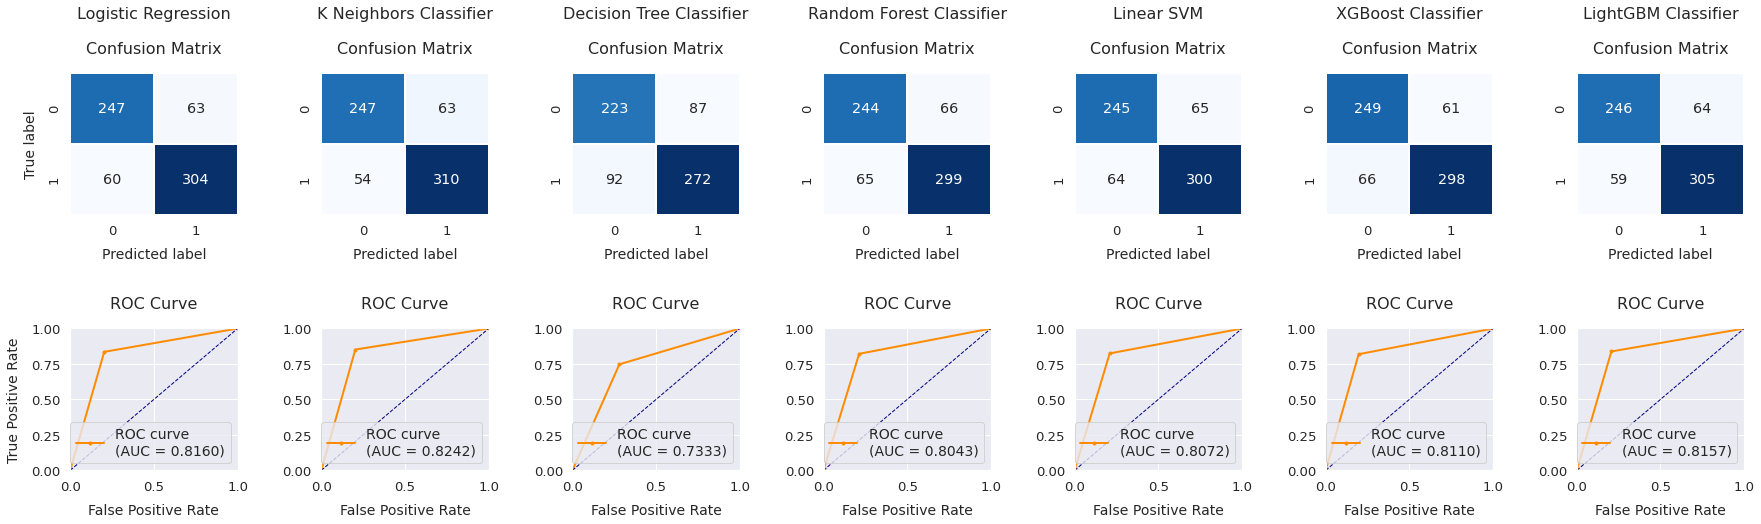

In [114]:
# models
score = 'accuracy'
clfs_preds = []
clfs_metrics = []

title=f'Comparison of classifiers trained on the full 4 center UCI Heart Disease Dataset ({n_folds} fold cross-validation). Predictions made using cross_val_predict'
print(title)
print('='*len(title))

print("Fitting and predicting Logistic Regression...")
lr_best, lr_params_best, lr_preds, lr_metrics = test_models_params(LogisticRegression(), lr_params, X_train, y_train, estimator='Logistic Regression')
clfs_preds.append(lr_preds)
clfs_metrics.append(lr_metrics)

print("Fitting and predicting K neighbors classifier...")
knn = KNeighborsClassifier()
knn_pipe_params = {'classifier__{}'.format(k): v for k, v in knn_params.items()}
knn_pipe = Pipeline([('scale', StandardScaler()), ('classifier', knn)])
knn_best, knn_params_best, knn_preds, knn_metrics = test_models_params(knn_pipe, knn_pipe_params, X_train, y_train, estimator='K Neighbors Classifier')
for key, value in knn_params_best.items():
    if 'classifier' in str(key): 
        x = str(key)[12:]
        knn_params_best[x] = knn_params_best.pop(key)
clfs_preds.append(knn_preds)
clfs_metrics.append(knn_metrics)

print("Fitting and predicting decision tree classifier...")
dt_best, dt_params_best, dt_preds, dt_metrics = test_models_params(DecisionTreeClassifier(), dt_params, X_train, y_train, estimator='Decision Tree Classifier')
clfs_preds.append(dt_preds)
clfs_metrics.append(dt_metrics)

print("Fitting and predicting random forest classifier...")
rf_best, rf_params_best, rf_preds, rf_metrics = test_models_params(RandomForestClassifier(), rf_params, X_train, y_train, estimator="Random Forest Classifier")
clfs_preds.append(rf_preds)
clfs_metrics.append(rf_metrics)

print("Fitting and predicting linear SVM Classifier...")
svc_best, svc_params_best, svc_preds, svc_metrics = test_models_params(LinearSVC(), svc_params, X_train, y_train, estimator="Linear SVM")
clfs_preds.append(svc_preds)
clfs_metrics.append(svc_metrics)

print("Fitting and predicting XGBoost Classifier...")
xgb_best, xgb_params_best, xgb_preds, xgb_metrics = test_models_params(XGBClassifier(), xgb_params, X_train_matrix, y_train_matrix, estimator="XGBoost Classifier")
clfs_preds.append(xgb_preds)
clfs_metrics.append(xgb_metrics)

print("Fitting and predicting LightGBM classifier...")
lgbm_best, lgbm_params_best, lgbm_preds, lgbm_metrics = test_models_params(LGBMClassifier(), lgbm_params, X_train, y_train, estimator="LightGBM Classifier")
clfs_preds.append(lgbm_preds)
clfs_metrics.append(lgbm_metrics)

print('Done!')

#Display results in a dataframe
clfs_cols = ['Estimator', 'Best training accuracy', 'Best params', 'Time to fit(s)', 'Time to score(s)', 'Precision', 'Recall', 'F1 score', 'Sensitivity (recall)', 'Specificity', 'AUC-ROC']
clfs_df = pd.DataFrame(data=clfs_metrics, columns = clfs_cols)
display(clfs_df)

fig, ax = plt.subplots(figsize=(30,12), sharey=True)

for i, preds in enumerate(clfs_preds):
    cm = confusion_matrix(y_train, preds)
    plt.subplot(3, 7, i+1)
    plot_cm(cm, idx=i, est=clfs_metrics[i][0])
    
for i, preds in enumerate(clfs_preds): 
    fpr, tpr, thresholds = roc_curve(y_train, preds)
    auc = clfs_metrics[i][10]
    plt.subplot(3, 7, i+8)
    plot_roc(fpr, tpr, auc, idx=i, est='')
      
sns.set(font_scale=1.4)
fig.subplots_adjust(wspace=.5, hspace=.8)
fig.show()

## Tune the best models with broader hyperparameter search 

In [115]:
# 1. KNN
from scipy.stats import randint as sp_randint
knn_params_tune = {'n_neighbors': [10, 12, 15, 14, 16, 20]}
knn_pipe_params = {'classifier__{}'.format(k): v for k, v in knn_params_tune.items()}
knn_pipe = Pipeline([('scale', StandardScaler()), ('classifier', knn)])
knn_tuned, knn_params_tuned, knn_preds, knn_tuned_metrics = test_models_params(knn_pipe, knn_pipe_params, X_train, y_train, estimator='K Neighbors Classifier')

#Display results in a dataframe
cols = ['Estimator', 'Best training accuracy', 'Best params', 'Time to fit(s)', 'Time to score(s)', 'Precision', 'Recall', 'F1 score', 'Sensitivity (recall)', 'Specificity', 'AUC-ROC']
df = pd.DataFrame(data=[knn_tuned_metrics], columns = cols)
display(df)

0.035170469513916974
0.8323604201216142


,Estimator,Best training accuracy,Best params,Time to fit(s),Time to score(s),Precision,Recall,F1 score,Sensitivity (recall),Specificity,AUC-ROC
0,K Neighbors Classifier,0.83236,{'classifier__n_neighbors': 15},0.005,0.016,0.831099,0.851648,0.841248,0.851648,0.796774,0.824211


In [116]:
# 2. RandomForestClassifier
rf_params_tune = {
              "n_estimators": sp_randint(4, 256),
              "max_depth": [None] + [sp_randint(1, 24)],
              "max_features": sp_randint(1, 12),
              "min_samples_split": sp_randint(2, 12),
              "bootstrap": [True, False],
              "criterion": ["gini", "entropy"],
              "n_jobs": [-1]}
rf_tuned, rf_params_tuned, rf_tuned_preds, rf_tuned_metrics = test_models_params(RandomForestClassifier(), rf_params_tune, X_train, y_train, search_func='randomized', n_iter=6, estimator="Random Forest Classifier")

#Display results in a dataframe
cols = ['Estimator', 'Best training accuracy', 'Best params', 'Time to fit(s)', 'Time to score(s)', 'Precision', 'Recall', 'F1 score', 'Sensitivity (recall)', 'Specificity', 'AUC-ROC']
df = pd.DataFrame(data=[rf_tuned_metrics], columns = cols)
display(df)

0.035761609039844655
0.8160309563294639


,Estimator,Best training accuracy,Best params,Time to fit(s),Time to score(s),Precision,Recall,F1 score,Sensitivity (recall),Specificity,AUC-ROC
0,Random Forest Classifier,0.816031,"{'bootstrap': True, 'criterion': 'gini', 'max_depth': None, 'max_features': 4, 'min_samples_split': 5, 'n_estimators': 56, 'n_jobs': -1}",0.525,0.051,0.836565,0.82967,0.833103,0.82967,0.809677,0.819674


## Feature selection

In [0]:
# Create a new transformation pipeline
# We will integrate feature selection into this pipeline
preprocessing_pipe_fs = Pipeline([
    ('cat_impute', cat_imputer), 
    ('cont_impute', cont_imputer),
    ('create_attribs', create_attribs),
])
# fit_transform the training set
X_train_fs = preprocessing_pipe_fs.fit_transform(X_train_base)
# for ease of use, create target dataframe
y_train_fs = y_train_base['target']

### 1. Select best set of uncorrolated features 

In [118]:
# Select the least corrolated features which give best performance using .corr() -> Pearson corrolation coefficient

class CorrolationSelector(TransformerMixin, BaseEstimator):
    def __init__(self, targs, cols_keep=[], threshold=None):
        self.targs = targs
        self.threshold = threshold
        self.cols_keep = cols_keep
    def transform(self, df):
        return df[self.cols_keep]
    def fit(self, X, *_):
        df = pd.concat([X, self.targs], axis=1)
        self.cols_keep = df.columns[df.corr()[df.columns[-1]].abs() > self.threshold]
        self.cols_keep = [c for c in self.cols_keep if c in X.columns]
        return self

def test_features_cv(model, params, X, y):
    grid = GridSearchCV(model, params, error_score=0)
    grid.fit(X,y)
    return grid.best_score_, grid.best_params_

# 1. Use the CorrolationSelector class with a classifier and gridsearch to find the best threshold parameter
sc = CorrolationSelector(targs=y_train_fs)
sc_pipe = Pipeline([('corrolation_selector', sc), ('classifier', knn_best)]) # classifier for gridsearch
sc_pipe_params = {'corrolation_selector__threshold': [0.05, 0.1, 0.2]
                 # add paramweters for classifier as well if required
                 }
acc, params = test_features_cv(sc_pipe, sc_pipe_params, X_train_fs, y_train_fs) 
print(f'Best accuracy: %.4f' % acc)
print(F'Best Parameters: {params}')

# 2. Run the CorrolationSelector with the best params to find out which features were kept
sc = CorrolationSelector(threshold=params['corrolation_selector__threshold'], targs=y_train_fs)
sc.fit_transform(X_train_fs)
print(f'{len(sc.cols_keep)} of {len(X_train_fs.columns)} features kept at threshold {params["corrolation_selector__threshold"]}')
# print(f'Features retained: {sc.cols_keep}')

# 3. We can now add the corrolation selector with optimized threshold values to our data processing pipeline
corrolation_selector = Pipeline([
    ("corrolation_selector", CorrolationSelector(threshold=params['corrolation_selector__threshold'], targs=y_train_fs))
])

Best accuracy: 0.8457
Best Parameters: {'corrolation_selector__threshold': 0.1}
38 of 68 features kept at threshold 0.1


### 2. Feature selection by hypothesis testing (ANOVA F-value)

In [119]:
# Feature selection by hypothesis testing (ANOVA F-value)
k_best = SelectKBest(f_classif)
select_k_pipe = Pipeline([('k_best', k_best), ('classifier', knn_best)])

# 1. Gridearch to find the best k parameter
select_k_best_pipe_params = {'k_best__k':list(range(20,50, 1))} # add paramweters for classifier as well if required
acc, params = test_features_cv(select_k_pipe, select_k_best_pipe_params, X_train_fs, y_train_fs)
print(f'Best accuracy: %.4f' % acc)
print(F'Best Parameters: {params}\n')

# 2. Run SelectKBest with the best parameters to get feature p_values
k_best = SelectKBest(f_classif, k=params['k_best__k'])
k_best.fit_transform(X_train_fs, y_train_fs)
p_values = pd.DataFrame({'column': X_train_fs.columns, 'p_value':k_best.pvalues_}).sort_values('p_value')

# Creat a class to integrate into our data processing platform
# ... which drops features with insignificant P-values below threshold (default 0.05)
# ... and are therefore irrelevant for classification (i.e.support the null hypothesis 
# ... that the feature has no relevance to the target variable)

class RelevenceSelector(TransformerMixin, BaseEstimator):
    def __init__(self, p_values, cols_keep=[], num_cols_keep=None, p_value_threshold=0.05):
        self.num_cols_keep = num_cols_keep
        self.p_value_threshold = p_value_threshold
        self.cols_keep = cols_keep
        self.p_values = p_values
    def transform(self, df):
        return df[self.cols_keep]
    def fit(self, X, *_):
        if self.num_cols_keep is not None:
            self.cols_keep = self.p_values.head[max(1, self.num_cols_keep)]
        else:
            self.cols_keep = self.p_values[self.p_values['p_value']<self.p_value_threshold]['column']
        return self
    
# 3. We can now add a relevance selector to our data processing pipeline
# ... takes either a number of columns or a threshold p_value as arguments
relevence_selector = Pipeline([
    ("relevence_selector", RelevenceSelector(p_values, num_cols_keep=params['k_best__k']))
])

Best accuracy: 0.8517
Best Parameters: {'k_best__k': 44}



In [120]:
# Automatically select best features using recursive feature elimination with cross-validation (RFECV)
rfecv = RFECV(estimator=LogisticRegression(), step=1, scoring='neg_mean_squared_error')
rfecv.fit_transform(X_train_fs, y_train_fs)
print(f'Keeping {np.count_nonzero(rfecv.support_ == True)} features out of {len(rfecv.support_)} ({np.count_nonzero(rfecv.support_ == False)} dropped)')

class RFECVSelector(TransformerMixin, BaseEstimator):
    def __init__(self, support, cols_keep=[]):
        self.cols_keep = cols_keep
        self.support = support
    def transform(self, df):
        return df.iloc[:, rfecv.support_]
    def fit(self, X, *_):
        return self

# RFECV outputs a boolean array of faetures to keep/drop 
# ... we use this to filter the dataset's features and keep only those 
# ... that improve the estimators score
rfecv_selector = Pipeline([
    ('rfecv_selector', RFECVSelector(rfecv.support_))
])

Keeping 15 features out of 68 (53 dropped)


### 4. Feature selection using feature importances

Feature importances from RandomForestClassifier 
Showing 29 out of 68 above threshold importance of 0.01)


,33,5,3,31,24,26,0,8,36,4,25,21,23,37,22,6,35,39,30,29,27,28,1,55,38,19,34,58,52
importance,0.0679904,0.0646903,0.0571819,0.0544914,0.0458692,0.0406865,0.0360246,0.0350774,0.0348312,0.0346802,0.0333465,0.0326706,0.0293501,0.0276602,0.0269139,0.0250763,0.0247786,0.024456,0.0228222,0.0214434,0.0209897,0.0187426,0.0177599,0.0148539,0.0140229,0.013877,0.010929,0.0104705,0.0101644
feature,oldpeak,cptype,painexer,exang,thalach,thalhrdiff,age,chol,rldlv5diff,relrest,thalrest,thaldur,met,rldv5e,thaltime,restbp,rldv5,thal,tbpddiff,trestbpd,tpeakbps,tpeakbpd,sex,chol_imp,ca,thalmeds,slope,thaltime_imp,slope_imp


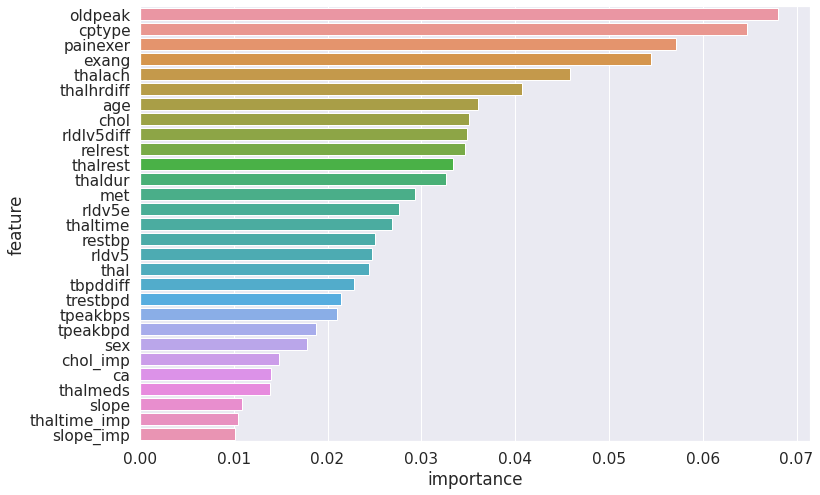

In [121]:
# Plot feature importances
rf_best.fit(X_train_fs, y_train_fs)
importances = list(rf_best.feature_importances_)
features = list(X_train_fs.columns)
df_importances = pd.DataFrame({'importance': importances,'feature': features}).sort_values('importance', ascending=False)

threshold_importance = 0.01
num_to_show = len([i for i in importances if i > threshold_importance]) # set number feature importances to display
print(f'Feature importances from RandomForestClassifier \nShowing {num_to_show} out of {df_importances.shape[0]} above threshold importance of {threshold_importance})')
display(df_importances.head(num_to_show).T)
plt = plt.figure(figsize=(12,8))
sns.barplot(x='importance', y='feature', data=df_importances[:num_to_show].sort_values('importance', ascending=False))
plt.show()

In [122]:
# 1. Make an ImportanceSelector class to add to our pipeline
class ImportanceSelector(TransformerMixin, BaseEstimator):
  def __init__(self, threshold=0.01):
    self.threshold = threshold
  def transform(self, df):
    return df[self.cols_to_keep]
  def fit(self, x, y):
    rf_best.fit(x, y)
    importances = list(rf_best.feature_importances_)
    features = list(x.columns)
    df = pd.DataFrame({'importance': importances,'feature': features}).sort_values('importance', ascending=False)
    self.cols_to_keep = df[df['importance'] > self.threshold]['feature'].tolist()
    return self

# 2. Select the best threshold value
res = (0, 0)
for x in [.0025, .005, .01, .02, .03, .04, .05]:
  s = ImportanceSelector(x)
  df_tr = s.fit_transform(X_train_fs, y_train_fs)
  _, _, _, metrics = test_models_params(knn_pipe, knn_pipe_params, df_tr, y_train, estimator='K Neighbors Classifier')
  print(f'Threshold importance: {x}, accuracy: {metrics[1]} with {len(df_tr.columns)} out of {len(X_train_fs.columns)} features')
  if metrics[1] > res[1]: res = (x, metrics[1])
best_thresh = res[0]
print(f'\nBest threshold: {best_thresh} with accuracy: {res[1]}')

# 3. We can now add a feature selection by importance to our data processing pipeline
# ... takes a importnace threshold as an arguement
importance_selector = Pipeline([
    ("importance_selector", ImportanceSelector(threshold=best_thresh))
])

0.034154655514047144
0.8412824765063572
Threshold importance: 0.0025, accuracy: 0.8412824765063572 with 51 out of 68 features
0.042559559722353035
0.8516749585406302
Threshold importance: 0.005, accuracy: 0.8516749585406302 with 41 out of 68 features
0.03440239517205233
0.8457379767827529
Threshold importance: 0.01, accuracy: 0.8457379767827529 with 29 out of 68 features
0.043709877249210265
0.8204975124378109
Threshold importance: 0.02, accuracy: 0.8204975124378109 with 21 out of 68 features
0.04364790927416822
0.8116307352128247
Threshold importance: 0.03, accuracy: 0.8116307352128247 with 12 out of 68 features
0.037937352345853055
0.795323383084577
Threshold importance: 0.04, accuracy: 0.795323383084577 with 7 out of 68 features
0.037158715332666487
0.801216141514649
Threshold importance: 0.05, accuracy: 0.801216141514649 with 4 out of 68 features

Best threshold: 0.005 with accuracy: 0.8516749585406302


## Feature Transformation (PCA & LDA)

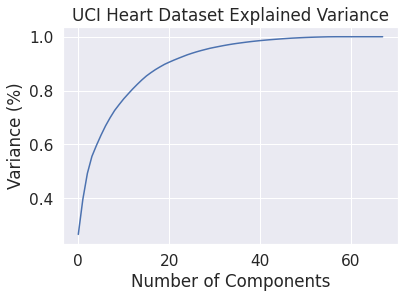

In [123]:
# first lets look at plot of explained variance to get a rough idea of how many  features carry most of the variance
import matplotlib.pyplot as plt
pca = PCA().fit(MinMaxScaler().fit_transform(X_train_fs))
#Plotting the Cumulative Summation of the Explained Variance
plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)') #for each component
plt.title('UCI Heart Dataset Explained Variance')
plt.show()

## Final data pipeline

This cell contains the complete data processing pipeline from preprocessing through to feature transformation. By commenting out different steps we can experiment to find the optimal set of steps to include in the final pipeline with our data. 

In [0]:
preprocessing = Pipeline([
    ('cat_impute', cat_imputer), 
    ('cont_impute', cont_imputer),
    ('create_attribs', create_attribs),
])

features = Pipeline([
#     ('corrolation_select', corrolation_selector),
#     ('relevance_select', relevence_selector),
    ('importance_select', importance_selector),
    # ('rfecv_select', rfecv_selector)
])

encode = Pipeline([
      ('modify_attribs', ModifyAttribs(cols=[])), # needed to avoid size mismatches between train and test with ohe using `dummify`
      ("dummify", Dummifier(cols=['cptype','thal', 'slope', 'restecg', 'ca'])),
      # ("label_encode", Encoder(cols=['cptype','thal', 'slope', 'restecg', 'ca'])),     
])

scale = Pipeline([
#     ('scale', Scaler(cols=['age', 'restbp', 'chol', 'oldpeak','thaldur', 'thaltime', 
#                            'met','thalhrdiff', 'tpeakbps', 'tbpddiff', 'tpeakbpd','trestbpd', 
#                            'thalach', 'thalrest', 'rldv5', 'rldv5e', 'rldlv5diff', ], 
#                             scaler='standard')),
      ('scale', StandardScaler())
])

transformation = Pipeline([
#     ('scale', StandardScaler()),
    ('pca', PCA(n_components=0.99)), 
#     ('lda', LinearDiscriminantAnalysis(n_components=10))
])

# Assemble final data processing pipline
pipe_final = Pipeline(steps=[
    ('preprocessing', preprocessing),
    ('features', features),
    ('encode', encode),
    ('scale', scale),
    ('transformation', transformation)
])


In [135]:
# Fit-transform train set (X_train) and transform the test set (X-test) with optimal data pipeline

model = KNeighborsClassifier()
knn_params_final = {'n_neighbors': [12, 14, 16, 18, 22, 24]}

# X_Train
X_train_final = pipe_final.fit_transform(X_train_base, y_train)
print("Fitting and transforming classifier...")

best_clf, params_best, preds, metrics = test_models_params(model, knn_params_final, X_train_final, y_train_fs, estimator='KNN')
print(params_best)
print(metrics)

# Test set
print('\nTransforming test set ...')
X_test_final = pipe_final.transform(X_test_base)
print('Complete')
print(f'Train - features retained: {X_train_final.shape[1]}')
print(f'Test - features retained: {X_test_final.shape[1]}')

Fitting and transforming classifier...
0.04220265213557946
0.8472194582642345
{'n_neighbors': 22}
['KNN', 0.8472194582642345, {'n_neighbors': 22}, 0.003, 0.013, 0.854701, 0.824176, 0.839161, 0.8241758241758241, 0.8354838709677419, 0.829829847571783]

Transforming test set ...
Complete
Train - features retained: 40
Test - features retained: 40


## Evaluate the best model(s) with the best selected features on the test set

**X_train_final** = train data processed with optimised data processing pipeline

**X_test_final** = test data processed with data processing pipeline

**y_test** = test set labels

**best_clf** = best classifier (knn classifier trained using final data processing pipeline)

### 1. KNeighboursClassifier

In [0]:
def get_metrics(y, y_hat, name):
    precision = round(precision_score(y, y_hat), 6),
    recall = round(recall_score(y, y_hat), 6),
    f1 = round(f1_score(y, y_hat), 6),
    cm = confusion_matrix(y, y_hat)
    sensitivity = round(cm[1,1]/(cm[1,1] + cm[1,0]), 6)
    specificity = round(cm[0,0]/(cm[0,0] + cm[0,1]), 6)
    auc = round(roc_auc_score(y, y_hat), 6)

    #Display results in a dataframe
    data = [[name, precision[0], recall[0], f1[0], sensitivity, specificity, auc]]
    cols = ['Estimator', 'Test: precision', 'Test: recall', 'Test: F1 score', 'Test: sensitivity', 'Test: specificity', 'Test: AUC-ROC']
    return pd.DataFrame(data=data, columns = cols)

KNeighborsClassifier results


,Estimator,Test: precision,Test: recall,Test: F1 score,Test: sensitivity,Test: specificity,Test: AUC-ROC
0,KNeighborsClassifier,0.868421,0.755725,0.808163,0.755725,0.840426,0.798075


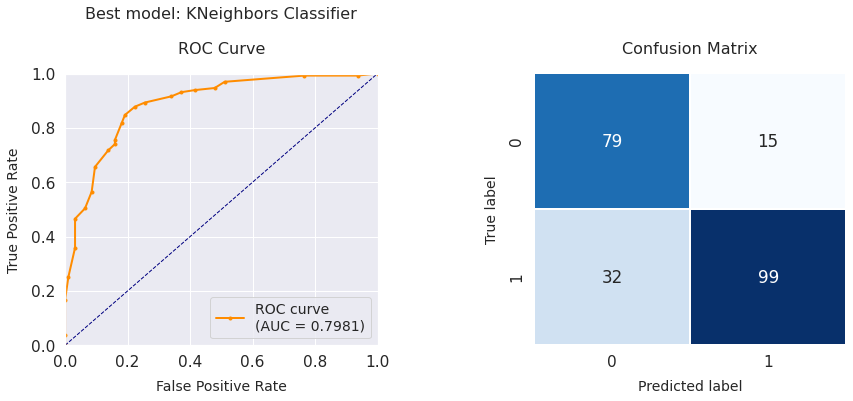

In [138]:
# get predictions using best classifier on test set transformed using final data processing pathway
y_pred = best_clf.predict(X_test_final) 

# get probabilities
y_probs = best_clf.predict_proba(X_test_final)

print('KNeighborsClassifier results')
best_model_knn_metrics = get_metrics(y_test, y_pred, name='KNeighborsClassifier')
display(best_model_knn_metrics)

fig, ax = plt.subplots(figsize=(14, 5))
plt.subplot(1,2,1)
fpr, tpr, threshold = roc_curve(y_test, y_probs[:,1])
auc = best_model_knn_metrics['Test: AUC-ROC']
plot_roc(fpr, tpr, auc, est='Best model: KNeighbors Classifier')
plt.subplot(1,2,2)
cm = confusion_matrix(y_test,y_pred)
plot_cm(cm, est='')
fig.subplots_adjust(wspace=.5)
sns.set(font_scale=1.4)
fig.show()

## Ensembling

Ensemble all the previously used classifiers by 
* voting
* stacking

to see if an ensemble can outperform the single best model. 

### VotingClassifier

Voting Ensemble results


,Estimator,Test: precision,Test: recall,Test: F1 score,Test: sensitivity,Test: specificity,Test: AUC-ROC
0,Ensemble (voting),0.850394,0.824427,0.837209,0.824427,0.797872,0.81115


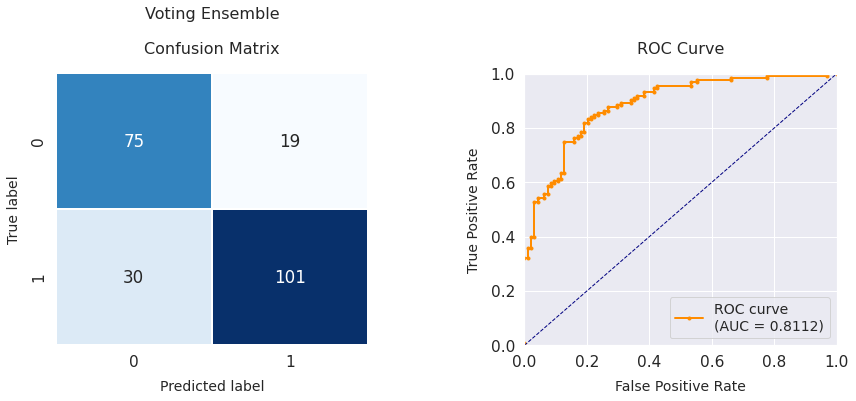

In [128]:
# Using sklearn VotingClassifier
from sklearn.ensemble import VotingClassifier

#create a dictionary of our models
# note, linearSVC is not included as it does not output probability scores
estimators=[('log_reg', lr_best), ('knn', knn_best), ('d_tree', dt_best), ('rf', rf_best), ('xgb', xgb_best), ('lgbm', lgbm_best)]
#create our voting classifier, inputting our models
voting_clf = VotingClassifier(estimators, voting='soft')                          
#fit model to training data
voting_clf.fit(X_train, y_train) 
#test our model on the test data
voting_preds = voting_clf.predict(X_test)
# get probabilities
voting_probs = voting_clf.predict_proba(X_test)

print('Voting Ensemble results')
voting_metrics = get_metrics(y_test, voting_preds, name='Ensemble (voting)')
display(voting_metrics)

fig, ax = plt.subplots(figsize=(14,5))
plt.subplot(1,2,1)
plot_cm(cm, est='Voting Ensemble')

plt.subplot(1,2,2)
fpr, tpr, _ = roc_curve(y_test, voting_probs[:,1])
plot_roc(fpr, tpr, voting_metrics['Test: AUC-ROC'], est='')
plt.xlabel("False Positive Rate", labelpad=10, fontsize='14')
plt.ylabel("True Positive Rate", fontsize='14', labelpad=10)

fig.subplots_adjust(wspace=.5)
sns.set(font_scale=1.2)
fig.show()

### Stacking ensemble

In [0]:
# Advanced ensemble method with 'stacking'.
from sklearn.model_selection import KFold

ntrain = X_train.shape[0]
ntest = X_test.shape[0]
SEED = 0 # for reproducibility
NFOLDS = 5 # set folds for out-of-fold prediction
kf = KFold(n_splits= NFOLDS, random_state=SEED)

In [0]:
def get_oof(clf, x_train, y_train, x_test):
    oof_train = np.zeros((ntrain))
    oof_test = np.zeros((ntest))
    oof_test_skf = np.empty((NFOLDS, ntest))

    for i, (train_index, test_index) in enumerate(kf.split(X_train)):
        x_tr = x_train[train_index]
        y_tr = y_train[train_index]
        x_te = x_train[test_index]
        
        clf.fit(x_tr, y_tr)
        oof_train[test_index] = clf.predict(x_te)
        oof_test_skf[i, :] = clf.predict(X_test)

    oof_test[:] = oof_test_skf.mean(axis=0)
    return oof_train.reshape(-1, 1), oof_test.reshape(-1, 1)

In [131]:
# Create our OOF train and test predictions. These base results will be used as new features
lr_oof_train, lr_oof_test = get_oof(LogisticRegression(**lr_params_best), X_train, y_train, X_test) # log reg
knn_oof_train, knn_oof_test = get_oof(KNeighborsClassifier(**knn_params_best),X_train, y_train, X_test) # KNN
dt_oof_train, dt_oof_test = get_oof(DecisionTreeClassifier(**dt_params_best), X_train, y_train, X_test) # decision tree
rf_oof_train, rf_oof_test = get_oof(RandomForestClassifier(**rf_params_best), X_train, y_train, X_test) # random forest
svc_oof_train, svc_oof_test = get_oof(LinearSVC(**svc_params_best), X_train, y_train, X_test) # Support Vector Classifier
xgb_oof_train, xgb_oof_test = get_oof(XGBClassifier(**xgb_params_best), X_train, y_train, X_test) # Light GBM
lgbm_oof_train, lgbm_oof_test = get_oof(LGBMClassifier(**lgbm_params_best), X_train, y_train, X_test) # Light GBM
print("Training layer one stacking ensemble complete")

# create base_predictions dataframe
base_predictions_train = pd.DataFrame( 
    {'log_reg': lr_oof_train.ravel(),
     'KNN': knn_oof_train.ravel(),
     'D_Tree': dt_oof_train.ravel(),
     'RandomForest': rf_oof_train.ravel(),
     'LinearSVC': svc_oof_train.ravel(),
     'XGBoost': xgb_oof_train.ravel(),
     'Light_GBM': lgbm_oof_train.ravel()
    })

Training layer one stacking ensemble complete


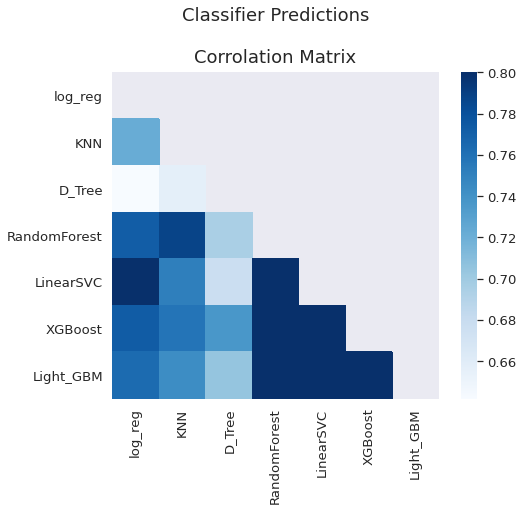

In [132]:
# Less corrolation between the classifiers is better for ensembling
fig,ax = plt.subplots(figsize=(8,6))
# sns.heatmap(base_predictions_train.corr(), cmap="Blues" ,ax=ax) # gives full square matrix
corr = base_predictions_train.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    ax = sns.heatmap(corr, mask=mask, cmap='Blues', vmax=.8, square=True)
plt.title('Classifier Predictions\n\nCorrolation Matrix', pad=10, fontsize='18')
plt.show()

Stacking ensemble results


,Estimator,Test: precision,Test: recall,Test: F1 score,Test: sensitivity,Test: specificity,Test: AUC-ROC
0,Ensemble (stacking),0.857143,0.824427,0.840467,0.824427,0.808511,0.816469


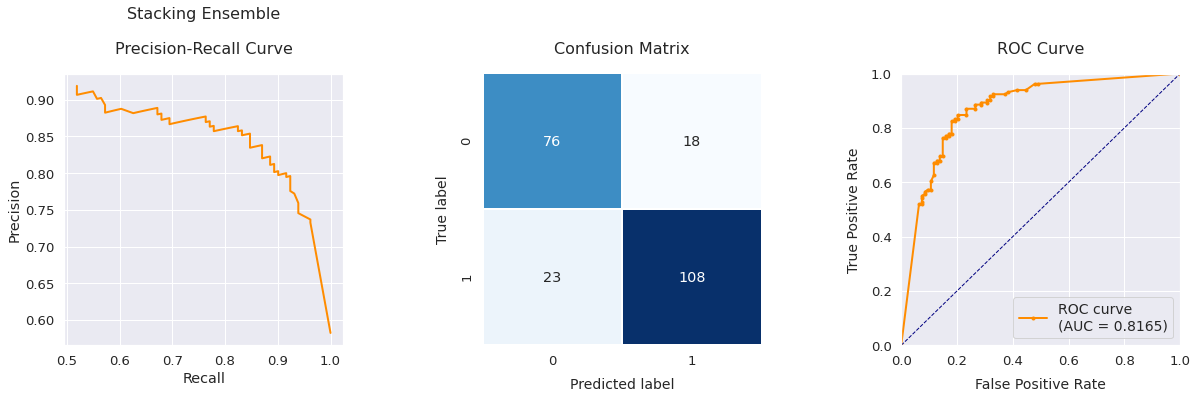

In [133]:
X_train_oof = np.concatenate(( lr_oof_train, knn_oof_train, dt_oof_train, rf_oof_train, svc_oof_train, xgb_oof_train, lgbm_oof_train), axis=1)
X_test_oof = np.concatenate(( lr_oof_test, knn_oof_test, dt_oof_test, rf_oof_test, svc_oof_test, xgb_oof_test, lgbm_oof_test), axis=1)

# lr_blender_best, lr_blender_params_best, lr_blender_preds, lr_blender_metrics = test_models_params(LogisticRegression(), lr_params, X_train_blender, y_train, test=X_test_blender, estimator='Logistic Regression_blender')
blender_clf = LogisticRegression(C=0.1, penalty='l2')
blender_clf.fit(np.array(X_train_oof), y_train)                       
# test our model on the test data
blender_preds = blender_clf.predict(X_test_oof)
# get probabilities
blender_probs = blender_clf.predict_proba(X_test_oof)
# get scores
blender_scores = blender_clf.decision_function(X_test_oof)

print('Stacking ensemble results')
blender_metrics = get_metrics(y_test, blender_preds, name='Ensemble (stacking)')
display(blender_metrics)

fig, ax = plt.subplots(figsize=(20,5))
plt.subplot(1,3,1)
precisions, recalls, _ = precision_recall_curve(y_test, blender_scores)
plot_pr_curve(precisions, recalls, est='Stacking Ensemble')

plt.subplot(1,3,2)
cm = confusion_matrix(y_test, blender_preds)
plot_cm(cm, est='')

plt.subplot(1,3,3)
fpr, tpr, _ = roc_curve(y_test, blender_probs[:,1])
plot_roc(fpr, tpr, blender_metrics['Test: AUC-ROC'], est='')

fig.subplots_adjust(wspace=.5)
sns.set(font_scale=1.2)
fig.show()